In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataset import KSponSpeechDataset, DataCollate
from torch.utils.data import DataLoader
from jamo import n_symbols, text_to_tokens, tokens_to_text

### Dataset

In [3]:
dataset = KSponSpeechDataset(root_dir='/data/KsponSpeech')
train_loader = DataLoader(dataset, num_workers=8, shuffle=True, batch_size=64, collate_fn=DataCollate())
print(train_loader)

622545


### Model

In [4]:
class Model(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv1d(input_channels, hidden_channels, kernel_size=3, padding=1),
                                  nn.BatchNorm1d(hidden_channels),
                                  nn.ReLU())
        self.lstm = nn.LSTM(input_size=hidden_channels, hidden_size=hidden_channels//2, num_layers=3, 
                            batch_first=True, dropout=0.1, bidirectional=True)
        self.out_layer = nn.Linear(hidden_channels, output_channels)
        self.criterion = nn.CTCLoss(zero_infinity=True)
        
    def forward(self, inputs, input_lengths, targets, target_lengths):
        # inputs : (B, T, C)
        # input_lengths : (B)
        # targets : (B, L)
        # target_lengths : (B)
        
        # (B, T, C)
        x = self.conv(inputs.transpose(1, 2)).transpose(1, 2)
        x = nn.utils.rnn.pack_padded_sequence(x, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = self.lstm(x)
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)
        log_probs = F.log_softmax(self.out_layer(x), dim=2)
        loss = self.criterion(log_probs.transpose(0, 1), targets, input_lengths, target_lengths)
        
        return log_probs, loss
        

### Logger

In [5]:
from utils import sizeof_fmt, Logger

In [6]:
!mkdir save
save_dir = 'save/ctc_lstm_kspon'
logger = Logger(save_dir=save_dir, new=False)
print(logger)

mkdir: cannot create directory ‘save’: File exists


In [7]:
!ls $save_dir

data.json   save_1552	save_35000  save_50000	save_70000
save_0	    save_20000	save_40000  save_55000	save_75000
save_10000  save_25000	save_45000  save_60000	save_76019
save_15000  save_30000	save_5000   save_65000


### Init Model

In [8]:
model = Model(input_channels=80, 
              hidden_channels=512, 
              output_channels=n_symbols)

model = model.cuda()
step = 76019

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
    print('loaded', step)

Model size 19.1MiB
loaded : 76019
loaded 76019


In [11]:
def to_cuda(batch):
    batch['audio'] = batch['audio'].cuda()
    batch['audio_lengths'] = batch['audio_lengths'].cuda()
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    
    return batch

### CTC Forward Function for Alignment Visualization

In [10]:
def ctc_forward(prob, target, time=None, length=None, blank=0):
    # prob : (time, labels)
    # target : (length)
    # time : the length of the prob
    # length : the length of the target
    
    if time is None:
        time = len(prob)
    if length is None:
        length = len(target)
        
    _t_a_r_g_e_t_ = np.concatenate([target[:length, None], np.zeros([length, 1]).astype(np.int)], axis=1)
    _t_a_r_g_e_t_ = _t_a_r_g_e_t_.reshape(-1)
    _t_a_r_g_e_t_ = np.pad(_t_a_r_g_e_t_, (1, 0))
    
    T1 = np.zeros([time, len(_t_a_r_g_e_t_)])
    
    # Init
    T1[0, 0] = prob[0, _t_a_r_g_e_t_[0]]
    T1[0, 1] = prob[0, _t_a_r_g_e_t_[1]]
    
    for j in range(2, len(_t_a_r_g_e_t_)):
        T1[0, j] = 0
    C = T1[0].sum()
        
    # Recursion
    for t in range(1, time):
        for s in range(len(_t_a_r_g_e_t_)):
            if s == 0:
                value = T1[t-1, s]
            else:
                value = T1[t-1, s] + T1[t-1, s-1]
                
            if _t_a_r_g_e_t_[s] == blank or (s>1 and _t_a_r_g_e_t_[s] == _t_a_r_g_e_t_[s-2]):
                pass
            else:
                if s>2:
                    value = value + T1[t-1, s-2]
                
            T1[t, s] = value * C * prob[t, _t_a_r_g_e_t_[s]]
            
        C = T1[t].sum()
        T1[t, :] = T1[t, :] / C
            
    return T1

In [13]:
import librosa.display
import matplotlib.pyplot as plt

def refine_tokens(tokens):
    prev_token = None
    new_tokens = []
    for token in tokens:
        if prev_token == token:
            continue
        
        if token == 0:
            prev_token = token
            continue
            
        new_tokens.append(token)
        prev_token = token
        
    return np.array(new_tokens)

def plot(batch, log_probs):
    _audio_lengths = batch['audio_lengths'].data.cpu().numpy()
    _audios = batch['audio'].data.cpu().numpy()
    _audio = _audios[0][:_audio_lengths[0]]
    _log_probs = log_probs.data.cpu().numpy()
    _log_prob = _log_probs[0][:_audio_lengths[0]]
    _text = batch['text'][0].data.cpu().numpy()
    _text_lengths = batch['text_lengths'].data.cpu().numpy()
    
    alpha = ctc_forward(np.exp(_log_prob), _text, time=_audio_lengths[0], length=_text_lengths[0])
    
    plt.figure(figsize=[18, 3])
    plt.title('Mel-spectrogram')
    librosa.display.specshow(_audio.T)
    plt.show()
    
    plt.figure(figsize=[18, 3])
    plt.title('Log-Probability')
    librosa.display.specshow(_log_prob.T)
    plt.show()
    
    plt.figure(figsize=[10, 4])
    plt.title('Forward Algorithm')
    plt.imshow(alpha.T, aspect='auto', origin='lower', interpolation='none')
    plt.show()
    
    print('Ground Truth')
    print(tokens_to_text(batch['text'][0, :batch['text_lengths'][0]].cpu().numpy()))
    print('Predicted Tokens')
    tokens_pred = _log_prob.argmax(axis=1)
    print(tokens_pred)
    print('Refined Tokens')
    tokens_refined = refine_tokens(tokens_pred)
    print(tokens_refined)
    print('Prediction')
    print(tokens_to_text(tokens_refined))
    

### Train

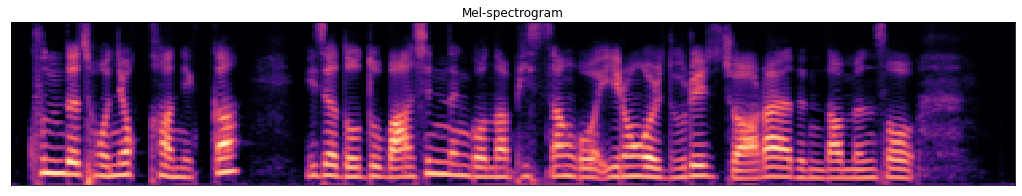

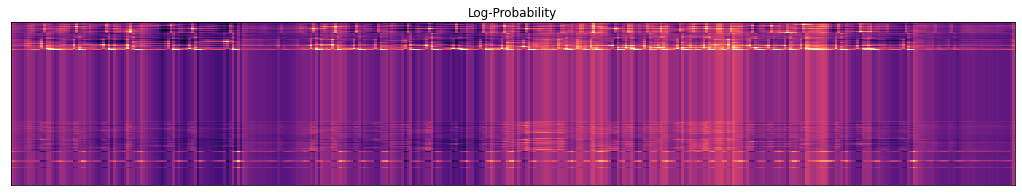

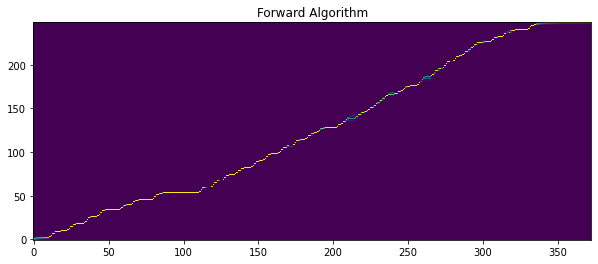

Ground Truth
 군대 전역하니까 이제 너도 맛있는 거나 비싼 거 이런 거 누릴 줄 알아야 된다면서 
Predicted Tokens
[  0   0   0   0   0   0   0   0   0   0   0 257 293 258 258 256 256 256
 256   0   0   0   0 259 297 256 256  32  32   0   0   0   0   0 265 289
 258 256   0   0   0   0   0 258 290 257 256 256   0   0   0   0   0   0
   0   0   0   0 270 287 256 256   0   0   0   0 258 296 256 256 256   0
   0   0   0   0   0   0   0   0 271 287 256 256  32  32  32   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0 264 296 256 256   0   0   0   0 265 299 256 256  32  32   0
   0 258 289 256 256   0   0   0   0 259 291 256 256  32  32   0   0   0
   0   0 261 287 263 256 256   0   0   0 264 296 274 256 256   0   0   0
   0   0 258 295 258 256 256 256  32   0   0   0 257 289 256 256   0   0
   0   0 258 287 256 256  32  32   0   0 262 296 256 256 256   0   0   0
   0   0   0   0   0 274 287 287 258 256 256  32   0   0   0   0   0 257
 289 256 256  32  32   0   0 264 296 256 256 2

In [20]:
from IPython import display

stop = True
while True: 
    for batch in train_loader:
        model.train()
        batch = to_cuda(batch)
        
        model.zero_grad()
        log_probs, loss = model(batch['audio'], batch['audio_lengths'], batch['text'], batch['text_lengths'])
        loss.backward()
        optimizer.step()
        
        if step % 10 == 0:
            print(step, loss.item())
            
        if step % 100 == 0:
            display.clear_output()
            plot(batch, log_probs)
            logger.log(step, 'loss', loss.item())
            if stop:
                break
    
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
    
        step += 1
    if stop:
        break


In [42]:
logger.save(step, model, optimizer)

saved save/ctc_lstm_kspon/save_76019
